In [3]:
 
import numpy as np 

  

# P1 = [105.3, 45.5, 258.8] # RAI

# P2 = [140.6, 211.6, 68.3] # LAI

P1 = [-105.3, -45.5, -258.8] # LPS 

P2 = [140.6, -211.6, -68.3] # LPS 

Origin = np.minimum(P1,P2) 

ROIExtent = np.absolute(np.subtract(P1,P2)) 

DesiredSpacing = 0.38 

DesiredSize  = ROIExtent / DesiredSpacing #= round 

DesiredSizeR = np.around(DesiredSize) 

  

print('Size:', DesiredSizeR) 

print('Origin:', Origin) 

print('Spacing:', DesiredSpacing) 

print(ROIExtent) 

print(DesiredSize) 

 

Size: [647. 437. 501.]
Origin: [-105.3 -211.6 -258.8]
Spacing: 0.38
[245.9 166.1 190.5]
[647.10526316 437.10526316 501.31578947]


In [22]:
################
# THIS PROGRAM WILL FIND THE MAXIMUM VALUES OF 1 AND 2 WITHIN AN ARRAY TO BE USED TO CROP AN IMAGE. WORKING RIGHT NOW
# MY ONLY EXISTING PROBLEM IS COPYING THE INFORMATION OF THE ORIGION AND SPACING OF ORIGINAL IMAGE TO THE CROPPED IMAGE

import SimpleITK as sitk
import numpy as np



#image_path ="H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"
#mask_path = "ZUNU_vida-lung-recentered.nii.gz"

image_path ="H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"
mask_path = "ZUNU_vida-lung-recentered.nii.gz"

# Load Lung Mask 
image = sitk.ReadImage(image_path)
cropim = sitk.ReadImage(image_path)

mask = sitk.ReadImage(mask_path)


# convert image array to numpy array
image_array = sitk.GetArrayFromImage(image)
mask_array = sitk.GetArrayFromImage(mask)

arr1 = mask_array
# size = [sizeflip[2],sizeflip[0],sizeflip[1]]

# # find the extremities of the matrix to find where 1s start 
indices = np.argwhere(arr1.any(-1))
print(indices)

indices_0 = np.argwhere(arr1 == 0)
indices_20 = np.argwhere(arr1 == 20)
indices_30 = np.argwhere(arr1 == 30)

max = indices_20.max(axis=0)
min = indices_20.min(axis=0)
max1 = indices_30.max(axis=0)
min1 = indices_30.min(axis=0)

point = image[250,250,250]
print(point)
# Max20 is  [521 431 499]
# Max30 is  [506 439 276]
# Min20 is  [ 55  71 249]
# Min30 is  [34 77 40] 
print("Max20 is ", max)
print("Max30 is ", max1)

print("Min20 is ", min)
print("Min30 is ", min1)

image.GetSize()
image.GetSpacing()
image.GetOrigin()

#Accessing image properties
size = image.GetSize()
# size = [sizeflip[2],sizeflip[0],sizeflip[1]]
spacing = (0.38, 0.38, 0.38)

# This needs to be a new origin that is calculated based upon the new Vx3
origin = image.GetOrigin()

# #Display image information
print("Image size:", size)
print("Spacing:", spacing)
print("Origin:", origin)



# Image Space Range
# Dependent upon

# Really dumb way to update maxs
maxxc = max[2]
maxxc1 = max1[2]
print("Maxxc = ", maxxc)
print("Maxxc1 = ", maxxc1)

if maxxc > maxxc1:
    maxx = maxxc

if maxxc < maxxc1:
    maxx = maxxc1

minxc = min[2]
minxc1 = min1[2]
if minxc < minxc1:
    minx = minxc


if minxc > minxc1:
    minx = minxc1

print("Minxc = ", minxc)
print("Minxc1 = ", minxc1)

maxyc = max[1]
maxyc1 = max1[1]
print("Maxyc = ", maxyc)
print("Maxyc1 = ", maxyc1)

if maxyc > maxyc1:
    maxy = maxyc

if maxyc < maxyc1:
    maxy = maxyc1

minyc = min[1]
minyc1 = min1[1]
if minyc < minyc1:
    miny = minyc

if minyc > minyc1:
    miny = minyc1
print("Minyc = ", minyc)
print("Minyc1 = ", minyc1)

maxzc = max[0]
maxzc1 = max1[0]

print("Maxzc = ", maxzc)
print("Maxzc1 = ", maxzc1)

if maxzc > maxzc1:
    maxz = maxzc

if maxzc < maxzc1:
    maxz = maxzc1

minzc = min[0]
minzc1 = min1[0]
if minzc < minzc1:
    minz = minzc

if minzc > minzc1:
    minz = minzc1

print("Minzc = ", minzc)
print("Minzc1 = ", minzc1)

#cropim = image[34:521, 71:439, 40:499]

#cropim = image[minx: maxx, miny:maxy, minz:maxz]
cropim.SetOrigin(origin)
cropim.SetSpacing(spacing)

# a = cropim.GetSize()
# b = cropim.GetSpacing()
# c = cropim.GetOrigin()
# print("Size of Crop image", a)
# print("Spacing", b)
# print("Origin", c)
# fvess = sitk.GetImageFromArray(image_array)

#original image
#sitk.WriteImage(fvess, "../Soheil/OG.nii.gz")

#cropped
# sitk.WriteImage(cropim, "CroppedCase24(2).nii.gz")


###### OUTPUT EXPECTED (VERIFIED ON 3D SLICER)
# size = (831, 654, 555) ish
# output origin = (-148.6, -307.707, -292.1) ish

# MAIN ISSUES are that...
# Vx3 will actually be larger as far as dimensions go, due to spacing
# need to find the values that are inputs for the Resample Image Filter




[[ 34 421]
 [ 34 423]
 [ 34 424]
 ...
 [521 282]
 [521 283]
 [521 285]]
132
Max20 is  [521 431 499]
Max30 is  [506 439 276]
Min20 is  [ 55  71 249]
Min30 is  [34 77 40]
Image size: (512, 512, 543)
Spacing: (0.38, 0.38, 0.38)
Origin: (-174.658203125, -358.158203125, -338.1000061035156)
Maxxc =  499
Maxxc1 =  276
Minxc =  249
Minxc1 =  40
Maxyc =  431
Maxyc1 =  439
Minyc =  71
Minyc1 =  77
Maxzc =  521
Maxzc1 =  506
Minzc =  55
Minzc1 =  34


In [51]:
################
# THIS PROGRAM WILL FIND THE MAXIMUM VALUES OF 1 AND 2 WITHIN AN ARRAY TO BE USED TO CROP AN IMAGE. WORKING RIGHT NOW
# MY ONLY EXISTING PROBLEM IS COPYING THE INFORMATION OF THE ORIGION AND SPACING OF ORIGINAL IMAGE TO THE CROPPED IMAGE

import SimpleITK as sitk
import numpy as np
import nibabel as nib
import nrrd




image_path ="H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"
mask_path = "ZUNU_vida-lung-recentered.nii.gz"

#####TEMPORARY

#image_path = "../Case 85/H-18621_IA210581_SPI-IA210581-PBV_EXPIRATION__0.5__QR40__3__A_80KV_Qr40d_3_49306369"

# Load Lung Mask
image = sitk.ReadImage(image_path)
cropim = sitk.ReadImage(image_path)
imagenib = nib.load(image_path)

mask = sitk.ReadImage(mask_path)

# convert image array to numpy array
image_array = sitk.GetArrayFromImage(image)
mask_array = sitk.GetArrayFromImage(mask)

arr1 = mask_array

# # find the extremities of the matrix to find where 1s start 

# indices_0 = np.argwhere(arr1 == 0)
# indices_20 = np.argwhere(arr1 == 20)
# indices_30 = np.argwhere(arr1 == 30)

# max = indices_20.max(axis=0)
# min = indices_20.min(axis=0)
# max1 = indices_30.max(axis=0)
# min1 = indices_30.min(axis=0)

# # Print the indices
# print("Indices of 0:", indices_0)
# print("Indices of 1:", indices_20)
# print("Indices of 2:", indices_30)

# Max20 is  [521 431 499]
# Max30 is  [506 439 276]
# Min20 is  [ 55  71 249]
# Min30 is  [34 77 40] 
# print("Max20 is ", max)
# print("Max30 is ", max1)

# print("Min20 is ", min)
# print("Min30 is ", min1)

shape = imagenib.shape
affine = imagenib.affine.shape
header = imagenib.header
# srowx = header['srow_x'] = [.38, 0, 0, 803]
# srowy = header['srow_y'] = [0, .38, 0, 662]
# srowz = header['srow_z'] = [0, 0, .38, 575]
# qoffsetx = header['qoffset_x'] = 803
# qoffsety = header['qoffset_y'] = 662
# qoffsetz = header['qoffset_z'] = 575
# new_affine = np.array([[.38, 0, 0, 803],
#                        [0, .38, 0, 662],
#                        [0, 0, .38, 575],
#                        [0, 0, 0, 1]])
target_affine = np.zeros((4, 4))
target_affine[0, 0] = target_affine[1, 1] = target_affine[2, 2] = 0.38
target_affine[0,3] = 803
target_affine[1,3] = 662
target_affine[2,3] = 575
target_affine[3,3] = 1
print("Target Affine:", target_affine)

image.GetSize()
image.GetSpacing()
image.GetOrigin()
# image.shape
#Accessing image properties
size = image.GetSize()
spacing = (0.38, 0.38, 0.38)
origin = image.GetOrigin()

# #Display image information
print("Image size:", size)
print("Spacing:", spacing)
print("Origin:", origin)
print("Nii.gz:", shape)
print("affine:", affine)
print("Header:", header)

# cropim.SetOrigin(origin)
# cropim.SetSpacing(spacing)

# # Image Space Range
# # Dependent upon

# cropim = image[34:521, 71:439, 40:499]

# minx = 
# maxx = 

# miny =
# maxy = 

# minz = 
# maxz = 
new_nifti = nib.Nifti1Image(imagenib, affine=target_affine, header=header)
header2 = new_nifti.header
print("Header 2:", header2)

# resampled_nii = resample_to_img(imagenib, affine == new_affine, new_nifti)\

# print("Data:", Data)

#data = new_nifti.get_fdata().astype('int16')

#nrrd.write('Vx3(1).nrrd', data)

# fvess = sitk.GetImageFromArray(image_array)

# #original image
# sitk.WriteImage(fvess, "../Soheil/OG.nii.gz")

# #cropped
# sitk.WriteImage(cropim, "../Soheil/Cropped.nii.gz")


Target Affine: [[3.80e-01 0.00e+00 0.00e+00 8.03e+02]
 [0.00e+00 3.80e-01 0.00e+00 6.62e+02]
 [0.00e+00 0.00e+00 3.80e-01 5.75e+02]
 [0.00e+00 0.00e+00 0.00e+00 1.00e+00]]
Image size: (512, 512, 543)
Spacing: (0.38, 0.38, 0.38)
Origin: (-174.658203125, -358.158203125, -338.1000061035156)
Nii.gz: (512, 512, 543)
affine: (4, 4)
Header: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 512 512 543   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.         0.68359375 0.68359375 0.5        1.         1.
 1.         1.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.

In [63]:
import SimpleITK as sitk

image_file_path = "H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"

# Replace these indices with the specific 3D point you want to query
point_indices = (42, 71, 34)

# Read the NIfTI image using SimpleITK
image = sitk.ReadImage(image_file_path)

# Get the physical point from the image
physical_point = image.TransformIndexToPhysicalPoint(point_indices)

# Get the intensity value at the given point
intensity_value = image.GetPixel(point_indices)

# Get the image spacing (physical distance between adjacent pixels)
original_spacing = image.GetSpacing()


# Get the image origin (physical coordinates of the origin in the image)
origin = image.GetOrigin()

# Get the image direction (direction cosines of the image axes)
direction = image.GetDirection()
new_spacing = (0.38, 0.38, 0.38)
image.SetSpacing(new_spacing)
new_origin = (-142.5, -300.2, -298.6)
image.SetOrigin(new_origin)
spacing = image.GetSpacing()
origin = image.GetOrigin()
dimensions = image.GetSize()
new_dimensions = [int(sz * spc / ns) for sz, spc, ns in zip(dimensions, original_spacing, new_spacing)]
resampled_image = sitk.Resample(image, new_dimensions, sitk.Transform(), sitk.sitkBSpline3, origin, new_spacing, image.GetDirection(), 0.0, image.GetPixelIDValue())

print("Physical Point:", physical_point)
print("Intensity Value:", intensity_value)
print("Spacing:", spacing)
print("Origin:", origin)
print("Direction:", direction)
print("Size:", dimensions)

new__space = resampled_image.GetSpacing()


# Get the image origin (physical coordinates of the origin in the image)
new__origin = resampled_image.GetOrigin()
new__shape = resampled_image.GetSize()

print("New", new__space)
print("New", new__origin)
print("New size:", new__shape)


output_image_file_path = "../NateCode/UpsampledVx3.nrrd"
sitk.WriteImage(resampled_image, output_image_file_path)


Physical Point: (-145.947265625, -309.623046875, -321.1000061035156)
Intensity Value: -980
Spacing: (0.38, 0.38, 0.38)
Origin: (-142.5, -300.2, -298.6)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Size: (512, 512, 543)
New (0.38, 0.38, 0.38)
New (-142.5, -300.2, -298.6)
New size: (921, 921, 714)


In [100]:
import SimpleITK as sitk

def get_physical_properties(image_path, point_indices):
    # Read the NIfTI image using SimpleITK
    image = sitk.ReadImage(image_path)

    # Get the physical point from the image
    physical_point = image.TransformIndexToPhysicalPoint(point_indices)

    # Get the intensity value at the given point
    intensity_value = image.GetPixel(point_indices)

    # Get the image spacing (physical distance between adjacent pixels)
    spacing = image.GetSpacing()

    # Get the image origin (physical coordinates of the origin in the image)
    origin = image.GetOrigin()

    # Get the image direction (direction cosines of the image axes)
    direction = image.GetDirection()

    return physical_point, intensity_value, spacing, origin, direction

if __name__ == "__main__":
    image_file_path = "H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"


    # Replace these indices with the specific 3D point you want to query
    point_indices = (50, 70, 30)

    # Call the function to get the physical properties
    physical_point, intensity_value, spacing, origin, direction = get_physical_properties(image_file_path, point_indices)

    print("Physical Point:", physical_point)
    print("Intensity Value:", intensity_value)
    print("Spacing:", spacing)
    print("Origin:", origin)
    print("Direction:", direction)


Physical Point: (-140.478515625, -310.306640625, -323.1000061035156)
Intensity Value: -1015
Spacing: (0.68359375, 0.68359375, 0.5)
Origin: (-174.658203125, -358.158203125, -338.1000061035156)
Direction: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [40]:
### This Code reads in a defined recentered ZUNU_vida-lung-recentered.nii.gz
### and finds the bounds of the lungs to Upsample the actual image given by the 
import SimpleITK as sitk
import numpy as np
import nibabel as nib

mask_path = "ZUNU_vida-lung-recentered(CASE42).nii.gz"
image_path= "H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"

# Read image with Simple ITK
image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

# convert image array to numpy array
transposed_array = sitk.GetArrayFromImage(image)
transposed_mask = sitk.GetArrayFromImage(mask)


#Search Mask array for density values of 0, 20, 30 of lungs
arr1 = transposed_mask

indices_0 = np.argwhere(arr1 == 0)
indices_20 = np.argwhere(arr1 == 20)
indices_30 = np.argwhere(arr1 == 30)

max = indices_20.max(axis=0)
min = indices_20.min(axis=0)
max1 = indices_30.max(axis=0)
min1 = indices_30.min(axis=0)

print("Max20 is ", max)
print("Max30 is ", max1)
print("Min20 is ", min)
print("Min30 is ", min1)

# For Case 42 I find these maxes/minumums
# Max20 is  [521 431 499]
# Max30 is  [506 439 276]
# Min20 is  [ 55  71 249]
# Min30 is  [34 77 40]

# The points below this line (min and max) are calculated using lines 50-95
# Lines 50-95 can definitely be simplified 
# min = (34, 71, 40) #transposed point 
# max = (521, 439, 499) #transposed point

#Lines 47-95 is a bad way to set 
maxxc = max[2]
maxxc1 = max1[2]
# print("Maxxc = ", maxxc)
# print("Maxxc1 = ", maxxc1)
if maxxc > maxxc1:
    maxx = maxxc
if maxxc < maxxc1:
    maxx = maxxc1
minxc = min[2]
minxc1 = min1[2]
if minxc < minxc1:
    minx = minxc
if minxc > minxc1:
    minx = minxc1
# print("Minxc = ", minxc)
# print("Minxc1 = ", minxc1)
maxyc = max[1]
maxyc1 = max1[1]
# print("Maxyc = ", maxyc)
# print("Maxyc1 = ", maxyc1)
if maxyc > maxyc1:
    maxy = maxyc
if maxyc < maxyc1:
    maxy = maxyc1
minyc = min[1]
minyc1 = min1[1]
if minyc < minyc1:
    miny = minyc
if minyc > minyc1:
    miny = minyc1
# print("Minyc = ", minyc)
# print("Minyc1 = ", minyc1)
maxzc = max[0]
maxzc1 = max1[0]
# print("Maxzc = ", maxzc)
# print("Maxzc1 = ", maxzc1)
if maxzc > maxzc1:
    maxz = maxzc
if maxzc < maxzc1:
    maxz = maxzc1
minzc = min[0]
minzc1 = min1[0]
if minzc < minzc1:
    minz = minzc
if minzc > minzc1:
    minz = minzc1
# print("Minzc = ", minzc)
# print("Minzc1 = ", minzc1)

def Physical_Point(x, y, z):
    index = [x, y, z]
    p1 = image.TransformIndexToPhysicalPoint((x, y, z))
    point1 = (p1[0], p1[1], p1[2])
    return(point1)
# x = 40
# y = 71
# z = 34

# Values in sitk.resampleimagefilter need to be Integers not Floats
x = int(minx)
y = int(miny)
z = int(minz)
# Find physical point of minimum
point1 = Physical_Point(x, y, z)

def Physical_Point(i, j, k):
    index = [i, j, k]
    p2 = image.TransformIndexToPhysicalPoint((i, j, k))
    point2 = (p2[0], p2[1], p2[2])
    return(point2)

# i = 499
# j = 439
# k = 521

i = int(maxx)
j = int(maxy)
k = int(maxz)
# Find physical point of max
point2 = Physical_Point(i, j, k)
# Print Physical Points to see them
print("Point 1:", point1)
print("Point 2:", point2)
 
# P1 = [134.3, 61.9, 140.7] # RAI
# P2 = [134.2, 238.6, 57.3] # LAI
# P1 = [-134.3, -61.9, -140.7] # LPS 
# P2 = [134.2, -238.6, 57.3] # LPS 
# Code to make Original Vx3
output_origin = np.minimum(point1,point2) 
ROIExtent = np.absolute(np.subtract(point1,point2)) 
DesiredSpacing = 0.38 

x1 = ROIExtent[0] / DesiredSpacing  
y1 = ROIExtent[1] / DesiredSpacing
z1 = ROIExtent[2] / DesiredSpacing
# Turn Floats into Integers
x2 = int(x1) + 10
y2 = int(y1) + 10
z2 = int(z1) + 10
# Chat GPT gave this to me in a function form but this could be edited 

def resample_image(input_image, new_size, output_origin, output_spacing, output_pixel_type, interpolator):
        # Create a resampler object
        resampler = sitk.ResampleImageFilter()

        #Set the interpolator
        resampler.SetInterpolator(interpolator)

        # Set the reference image for output size, origin, and spacing
        # resampler.SetOutputParametersFromImage(input_image)

        # Set the new output size, origin, and spacing
        resampler.SetSize(new_size)
        resampler.SetOutputOrigin(output_origin)
        resampler.SetOutputSpacing(output_spacing)

        # Set the output pixel type
        resampler.SetOutputPixelType(output_pixel_type)

        # Perform the resampling
        output_image = resampler.Execute(input_image)

        return(output_image)
# Setting Variables before calling function        
output_pixel_type = sitk.sitkInt16
output_spacing = (.38, .38, .38)
interpolator = sitk.sitkBSpline3
output_size = (x2, y2, z2)

output_image_path = "../Vx3/Vx3.nrrd"
output_image = resample_image(image, output_size, output_origin, output_spacing, output_pixel_type, interpolator)
sitk.WriteImage(output_image, output_image_path)

print("Vx3 was created!")
print("Output Image Dimensions: ", output_size)
print("Output Image Spacing: ", output_spacing)
print("Output Image Origin: ", output_origin)


Max20 is  [521 431 499]
Max30 is  [506 439 276]
Min20 is  [ 55  71 249]
Min30 is  [34 77 40]
Point 1: (-147.314453125, -309.623046875, -321.1000061035156)
Point 2: (166.455078125, -58.060546875, -77.60000610351562)
Vx3 was created!
Output Image Dimensions:  (835, 672, 650)
Output Image Spacing:  (0.38, 0.38, 0.38)
Output Image Origin:  [-147.31445312 -309.62304688 -321.1000061 ]
Output Image Size:  (835, 672, 650)


Max20 is  [521 431 499]
Max30 is  [506 439 276]
Min20 is  [ 55  71 249]
Min30 is  [34 77 40]
Point 1: (-147.314453125, -309.623046875, -321.1000061035156)
Point 2: (166.455078125, -58.060546875, -77.60000610351562)
(512, 512, 543)
(0.68359375, 0.68359375, 0.5)
Vx3 was created!
Output Image Dimensions:  (835, 672, 650)
Output Image Spacing:  (0.38, 0.38, 0.38)
Output Image Origin:  [-147.31445312 -309.62304688 -321.1000061 ]
835
672
650
Midpoint: =  193.6115264892578


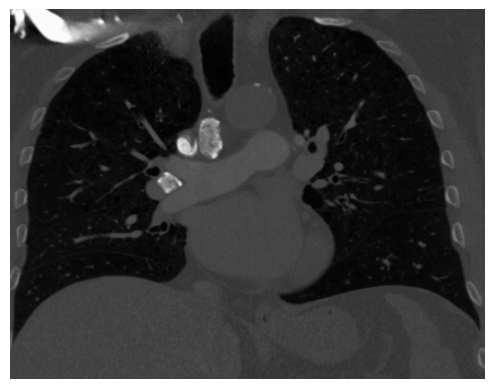

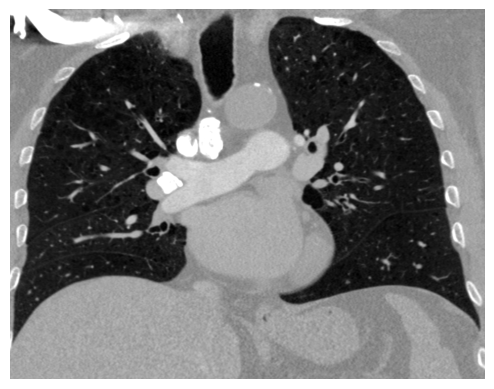

In [31]:
import SimpleITK as sitk
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

mask_path = "ZUNU_vida-lung-recentered(CASE42).nii.gz"
image_path= "H-17900_IA210257_SPI-IA210257-PBV_EXPIRATION_0.75_Qr40_A_80kV_67503688.nii.gz"

# Read image with Simple ITK

image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

# convert image array to numpy array

transposed_array = sitk.GetArrayFromImage(image)
transposed_mask = sitk.GetArrayFromImage(mask)

# Transpose the array
# image_array = np.transpose(transposed_array, (2, 1, 0))
# mask_array = np.transpose(transposed_array, (2, 1, 0))

# image_array_shape = image_array.shape
# mask_array_shape = mask_array.shape

arr1 = transposed_mask

indices_0 = np.argwhere(arr1 == 0)
indices_20 = np.argwhere(arr1 == 20)
indices_30 = np.argwhere(arr1 == 30)

max = indices_20.max(axis=0)
min = indices_20.min(axis=0)
max1 = indices_30.max(axis=0)
min1 = indices_30.min(axis=0)

print("Max20 is ", max)
print("Max30 is ", max1)
print("Min20 is ", min)
print("Min30 is ", min1)

# Max20 is  [521 431 499]
# Max30 is  [506 439 276]
# Min20 is  [ 55  71 249]
# Min30 is  [34 77 40]

## two points needed
#indices of numpy array
###(0, 205, 492)
###(343, 476, 542))
# low(34, 71, 40) #transposed point 
# max(521, 439, 499) #transposed point
maxxc = max[2]
maxxc1 = max1[2]
# print("Maxxc = ", maxxc)
# print("Maxxc1 = ", maxxc1)
if maxxc > maxxc1:
    maxx = maxxc
if maxxc < maxxc1:
    maxx = maxxc1
minxc = min[2]
minxc1 = min1[2]
if minxc < minxc1:
    minx = minxc
if minxc > minxc1:
    minx = minxc1
# print("Minxc = ", minxc)
# print("Minxc1 = ", minxc1)
maxyc = max[1]
maxyc1 = max1[1]
# print("Maxyc = ", maxyc)
# print("Maxyc1 = ", maxyc1)
if maxyc > maxyc1:
    maxy = maxyc
if maxyc < maxyc1:
    maxy = maxyc1
minyc = min[1]
minyc1 = min1[1]
if minyc < minyc1:
    miny = minyc
if minyc > minyc1:
    miny = minyc1
# print("Minyc = ", minyc)
# print("Minyc1 = ", minyc1)
maxzc = max[0]
maxzc1 = max1[0]
# print("Maxzc = ", maxzc)
# print("Maxzc1 = ", maxzc1)
if maxzc > maxzc1:
    maxz = maxzc
if maxzc < maxzc1:
    maxz = maxzc1
minzc = min[0]
minzc1 = min1[0]
if minzc < minzc1:
    minz = minzc
if minzc > minzc1:
    minz = minzc1
# print("Minzc = ", minzc)
# print("Minzc1 = ", minzc1)
size = image.GetSize()
spacing = image.GetSpacing()
def Physical_Point(x, y, z):
    index = [x, y, z]
    p1 = image.TransformIndexToPhysicalPoint((x, y, z))
    point1 = (p1[0], p1[1], p1[2])
    return(point1)
# x = 40
# y = 71
# z = 34
# Trying this
x = int(minx)
y = int(miny)
z = int(minz)
point1 = Physical_Point(x, y, z)

def Physical_Point(i, j, k):
    index = [i, j, k]
    p2 = image.TransformIndexToPhysicalPoint((i, j, k))
    point2 = (p2[0], p2[1], p2[2])
    return(point2)
# i = 499
# j = 439
# k = 521
i = int(maxx)
j = int(maxy)
k = int(maxz)
point2 = Physical_Point(i, j, k)
print("Point 1:", point1)
print("Point 2:", point2)
print(size)
print(spacing) 

# P1 = [134.3, 61.9, 140.7] # RAI
# P2 = [134.2, 238.6, 57.3] # LAI
# P1 = [-134.3, -61.9, -140.7] # LPS 
# P2 = [134.2, -238.6, 57.3] # LPS 

output_origin = np.minimum(point1,point2) 
ROIExtent = np.absolute(np.subtract(point1,point2)) 
DesiredSpacing = 0.38 

x1 = ROIExtent[0] / DesiredSpacing #= round 
y1 = ROIExtent[1] / DesiredSpacing
z1 = ROIExtent[2] / DesiredSpacing

x3 = x1 + 10
y3 = y1 + 10
z3 = z1 + 10
x2 = int(x3)
y2 = int(y3)
z2 = int(z3)

# 3,4,5
# starting index = max(0,yourcalculatedindex-10)
# floating

# def resample_image(input_image, new_size, output_origin, output_spacing, output_pixel_type, interpolator):
#         # Create a resampler object
#         resampler = sitk.ResampleImageFilter()
#         #Set the interpolator
#         resampler.SetInterpolator(interpolator)
#         # Set the reference image for output size, origin, and spacing
#         # resampler.SetOutputParametersFromImage(input_image)
#         # Set the new output size, origin, and spacing
#         resampler.SetSize(new_size)
#         resampler.SetOutputOrigin(output_origin)
#         resampler.SetOutputSpacing(output_spacing)
#         # Set the output pixel type
#         resampler.SetOutputPixelType(output_pixel_type)
#         # Perform the resampling
#         output_image = resampler.Execute(input_image)
#         return(output_image)     

output_pixel_type = sitk.sitkInt16
output_spacing = (.38, .38, .38)
interpolator = sitk.sitkBSpline3
output_size = (x2, y2, z2)
# print('Size:', SIZE)
# SIZE = (825, 662, 641)
# OUTPUT_ORIGIN = (-142.5, -300.2, -298.6)
output_image_path = "../Vx3/Vx3.nrrd"
#output_image = resample_image(image, output_size, output_origin, output_spacing, output_pixel_type, interpolator)
#sitk.WriteImage(output_image, output_image_path)

print("Vx3 was created!")
print("Output Image Dimensions: ", output_size)
print("Output Image Spacing: ", output_spacing)
print("Output Image Origin: ", output_origin)

Vx3_path = "../Vx3/Vx3.nrrd"

# Load the 3D image
Vx3 = sitk.ReadImage(Vx3_path)

# Get the size of the image in x, y, and z dimensions
size_x, size_y, size_z = Vx3.GetSize()
y_index = Vx3.GetSize()[1] // 2

print(size_x)
print(size_y)
print(size_z)

# Calculate the middle index along the y-dimension
midpoint = np.abs(point1[1] + point2[2]) / 2
print("Midpoint: = ", midpoint)
flip_axis = [1]

# Extract the middle plane along the y-dimension
# middle_plane = Vx3[size_x-1, int(midpoint), size_z-1]
slice_2d = Vx3[:,y_index,:]
flipped_slice_2d = sitk.Flip(slice_2d)
slice_array = sitk.GetArrayFromImage(flipped_slice_2d)
window_level_min = -1024  # Adjust these values according to your preference
window_level_max = 650
windowed_image = sitk.IntensityWindowing(flipped_slice_2d, window_level_min, window_level_max, 0, 255)
windowed_slice_array = sitk.GetArrayFromImage(windowed_image)
plt.imshow(slice_array, cmap="gray",origin='lower')
plt.axis("off")
plt.show()

plt.imshow(windowed_slice_array, cmap="gray",origin='lower')
plt.axis("off")
plt.show()

output_path = "../Vx3/QC_Image.png"  # Replace with the desired output file path
plt.imsave(output_path, windowed_slice_array, cmap="gray", origin='lower')
# scaling_factor = 0.1
# scaled_middle_plane = sitk.Resample(middle_plane, size_x * scaling_factor), (size_z * scaling_factor)
# print(middle_plane.GetSize())
# print(scaled_middle_plane.GetSize())
# Convert the SimpleITK image to a NumPy array for further processing (optional)
# middle_plane_array = sitk.GetArrayViewFromImage(middle_plane)

# # Save the middle plane as a 2D image file
# output_image_path = "../Vx3/middle_plane.png"
# sitk.WriteImage(middle_plane, output_image_path)
# scaled_middle_plane_array = sitk.GetArrayViewFromImage(scaled_middle_plane)

# Save the scaled middle plane as a 2D image file
# output_image_path = "../Vx3/scaled_middle_plane.png"
# sitk.WriteImage(scaled_middle_plane, output_image_path)





672
480
588


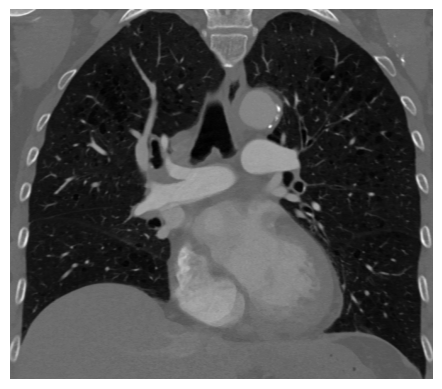

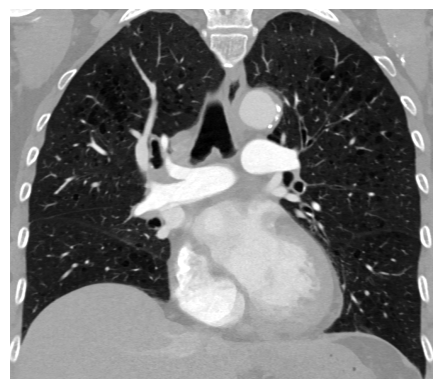

In [68]:
###THIS CODE WORKS TO MAKE .PNG files from Vx3s
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

Vx3_path = "../Vx3/Vx3(CASE73).nrrd"

# Load the 3D image
Vx3 = sitk.ReadImage(Vx3_path)

# Get the size of the image in x, y, and z dimensions
size_x, size_y, size_z = Vx3.GetSize()
y_index = Vx3.GetSize()[1] // 2
print(size_x)
print(size_y)
print(size_z)
# Extract the middle plane along the y-dimension
slice_2d = Vx3[:,y_index,:]
slice_array = sitk.GetArrayFromImage(slice_2d)
window_level_min = -1024  # Adjust these values according to your preference
window_level_max = 650
windowed_image = sitk.IntensityWindowing(slice_2d, window_level_min, window_level_max, 0, 255)
windowed_slice_array = sitk.GetArrayFromImage(windowed_image)

#Show Vx3
plt.imshow(slice_array, cmap="gray",origin='lower')
plt.axis("off")
plt.show()
#Show Vx3 with correct window level
plt.imshow(windowed_slice_array, cmap="gray",origin='lower')
plt.axis("off")
plt.show()

# output_path = "../Vx3/QC_Image4.png"  # Replace with the desired output file path
# plt.imsave(output_path, windowed_slice_array, cmap="gray", origin='lower')



TypeError: stat: path should be string, bytes, os.PathLike or integer, not module

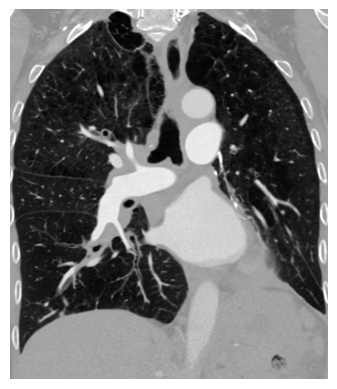

In [76]:
import os
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlsxwriter

workbook = xlsxwriter.Workbook("../Vx3/QCImages/Vx3_Images.xlsx")
worksheet = workbook.add_worksheet()
worksheet.set_column("B1:B5", 7)
worksheet.set_default_row(45)

# Function to extract the middle slice from the coronal view
def extract_coronal_middle_slice(image):
    y_index = image.GetSize()[1] // 2
    slice_2d = image[:, y_index, :]
    return slice_2d

def get_png_image(slice_2d):
    windowed_image = sitk.IntensityWindowing(slice_2d, -1024, 650)
    windowed_slice_array = sitk.GetArrayFromImage(windowed_image)
    plt.imshow(windowed_slice_array, cmap="gray", origin="lower")
    plt.axis("off")
    return plt

# Input directory containing "Vx3.nrrd" files
input_directory = "../Vx3"  # Replace with the actual directory path

# Output directory where .png images will be saved (not used in this version)
output_directory = "../Vx3/QCImages"  # Replace with the desired output directory path
file_list= []
image_list = []


# Traverse the input directory and process each "Vx3.nrrd" file
for root, dirs, files in os.walk(input_directory):
    for file in files:
        if file.endswith("Vx3.nrrd"):
            input_path = os.path.join(root, file)

            # Load the 3D medical image as a .nrrd file
            image = sitk.ReadImage(input_path)

            # Extract the middle slice from the coronal view
            slice_2d = extract_coronal_middle_slice(image)

            # Construct the output file name for .png
            plt_img = get_png_image(slice_2d)

            # Append the .png file name to the list for Excel export
            file_list.append(output_filename)
            image_list.append(plt_img)

image_row = 0
image_col = 1
for image in image_list:
    worksheet.insert_image(image_row, image_col, image, {"x_scale": 0.5,"y_scale": 0.5, "x_offset": 5,"y_offset": 5, "positioning" : 1})
    image_row += 1
workbook.close()

In [71]:
import os
import pandas as pd
import xlsxwriter
from PIL import Image

# Input directory containing the folders with .png images
input_directory = "../Vx3"  # Replace with the actual directory path

# Output directory where .png images will be saved (not used in this version)
output_directory = "../Vx3/QCImages" #place with the desired output Excel file path

# List to store the image file paths
image_list = []

# Traverse the input directory and process each folder
for root, dirs, files in os.walk(input_directory):
    for folder in dirs:
        folder_path = os.path.join(root, folder)
        # Check if the folder contains a .png file
        png_files = [file for file in os.listdir(folder_path) if file.endswith(".png")]
        if len(png_files) == 1:
            png_file_path = os.path.join(folder_path, png_files[0])
            image_list.append(png_file_path)

# Export the images to an Excel file
excel_output_file = "../Vx3/QCImages/Vx3_filenames.xlsx"
workbook = xlsxwriter.Workbook(excel_output_file)
worksheet = workbook.add_worksheet()

# Set the column width for the images
worksheet.set_column("A:A", 20)

# Add the images to the worksheet
for index, image_path in enumerate(image_list):
    img = Image.open(image_path)
    worksheet.insert_image(index, 0, image_path, {'image_data': img})

# Close the Excel writer
workbook.close()

AttributeError: getvalue